# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [15]:
class CTK_CRNN_Net(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTK_CRNN_Net, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [(3, 3), (3, 3)]
        pool_kernel = [(1, 1), (1, 1)]
        rnn_layer = [1]
        rnn_unit = [64]
        rnn_drop = [0]
        fc_unit = []
        drop_out = []
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[1], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - np.array(conv_kernel[0]) + 1.0) / np.array(pool_kernel[0]))
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - np.array(conv_kernel[1]) + 1.0) / np.array(pool_kernel[1]))
        
        fc_input_size = np.int(np.prod(img_size) * conv_channel[1])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0], generator = None), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0], generator = None))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0], generator = None)   # for simple RNN and GRU
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.sigmoid(x)
        
        return x

In [17]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTK_CRNN_Net(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [14]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [18]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [19]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 9] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = False # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = True # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = 60 # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = 10 # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 50,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [20]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (11, 14, 129, 60)
Single output data size: (4,)


In [21]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])


CTK_CRNN_Net(
  (conv1): Conv2d(14, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (rnn1): LSTM(35000, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)



1/5 Fold
----------------------------


/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.14110280722379684 0.1272422048366732 0.14382303603703067
Train/Val/TEST Accuracy: 55.072463768115945 61.111111111111114 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.1267314076423645 0.1123308301385906 0.13819750575792222
Train/Val/TEST Accuracy: 53.6231884057971 66.66666666666667 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.12236745208501816 0.1108334113119377 0.14867140747429358
Train/Val/TEST Accuracy: 53.6231884057971 66.66666666666667 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.12400677353143692 0.11221800247828166 0.15205365224253564
Train/Val/TEST Accuracy: 53.6231884057971 66.66666666666667 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.1252445787191391 0.11614620809753735 0.14405941346748954
Train/Val/TEST Accuracy: 53.6231884057971 66.66666666666667 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.11674554049968719 0.11628008095754518 0.14064914365077302
T

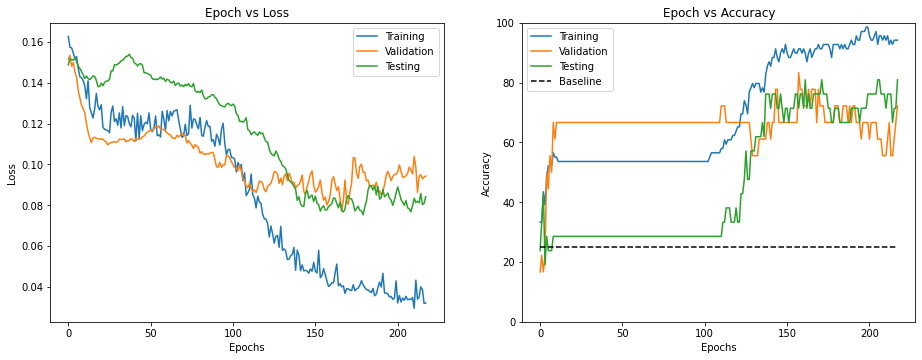

Train/Val/Test Final MSE: [0.04005681872367859, 0.07721271883282396, 0.07742345275446064]
Train/Val/Test Maximum Accuracy: [89.85507246376811, 77.77777777777777, 76.19047619047619]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.14610714316368104 0.12608088180422783 0.13562995550178347
Train/Val/TEST Accuracy: 59.42028985507246 38.888888888888886 38.095238095238095
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.12446231245994568 0.11417833674285147 0.1459762149800857
Train/Val/TEST Accuracy: 57.971014492753625 50.0 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.12861778736114501 0.11442155887683232 0.14958797195660217
Train/Val/TEST Accuracy: 57.971014492753625 50.0 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.12706876248121263 0.11708775638706154 0.14500211294563042
Train/Val/TEST Accuracy: 57.971014492753625 50.0 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.11876510828733444 0.10968472849991587 0.1409889388652075
Train/Val/TEST Accuracy: 57.971014492753625 50.0 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.12042802423238755 0.11002067145374086 0.13943961848105704
Train/Val/TEST Accuracy: 57.971014492753625

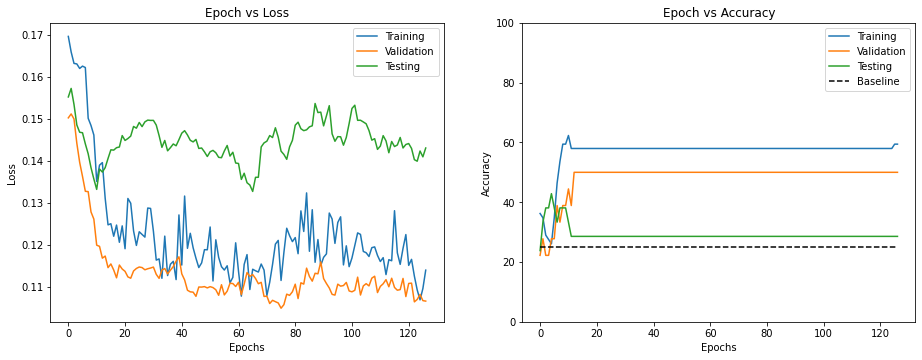

Train/Val/Test Final MSE: [0.11145846843719483, 0.10484619190295537, 0.14226043614603223]
Train/Val/Test Maximum Accuracy: [57.971014492753625, 50.0, 28.571428571428573]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.1322064459323883 0.15620997854891946 0.143303544038818
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 33.333333333333336
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.11113436073064804 0.14619350477176554 0.14115508016021477
Train/Val/TEST Accuracy: 55.714285714285715 58.8235294117647 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.1008781224489212 0.1504875226494144 0.15426060996417487
Train/Val/TEST Accuracy: 55.714285714285715 58.8235294117647 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08994860723614692 0.15099443933543036 0.1536427174827882
Train/Val/TEST Accuracy: 55.714285714285715 58.8235294117647 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.08520942777395249 0.143742505899247 0.15407449674482146
Train/Val/TEST Accuracy: 57.142857142857146 58.8235294117647 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.08188306540250778 0.1414685078403529 0.15508482299212897
Tr

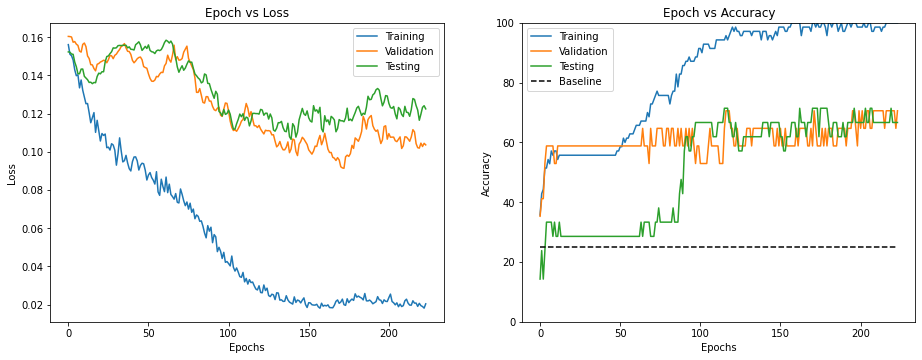

Train/Val/Test Final MSE: [0.01995192039757967, 0.09135759052108317, 0.11573300271161965]
Train/Val/Test Maximum Accuracy: [98.57142857142857, 64.70588235294117, 71.42857142857143]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.13712970167398453 0.15985826227594824 0.1411357575229236
Train/Val/TEST Accuracy: 55.714285714285715 52.94117647058823 33.333333333333336
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.11801917850971222 0.1366853567168993 0.1403134788963057
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.1010604202747345 0.13570023371892817 0.1458272687381222
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09866136461496353 0.13641540421282544 0.14530155209026166
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.079485122859478 0.12375394112485297 0.1442164307726281
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.06465470194816589 0.12726576626300812 0.130159839100780

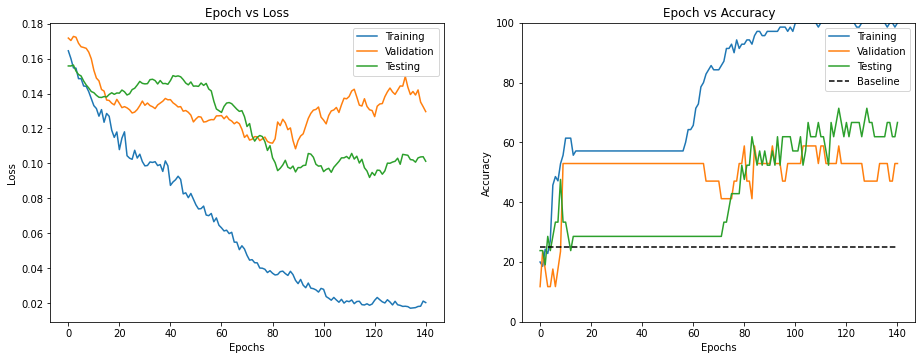

Train/Val/Test Final MSE: [0.03311027884483338, 0.10840479668010683, 0.09515660992335706]
Train/Val/Test Maximum Accuracy: [97.14285714285714, 52.94117647058823, 52.38095238095238]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.14039275348186492 0.17261401037959492 0.14388597508271536
Train/Val/TEST Accuracy: 54.285714285714285 41.1764705882353 33.333333333333336
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.1188712015748024 0.1490490239332704 0.13649462908506393
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.11430498957633972 0.15267471224069595 0.14744396898008527
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.10698476582765579 0.14944768368321307 0.14500872356196245
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.11143219619989395 0.14467192222090328 0.14491927818883032
Train/Val/TEST Accuracy: 57.142857142857146 52.94117647058823 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.10479414314031602 0.14342156578512752 0.1467326772

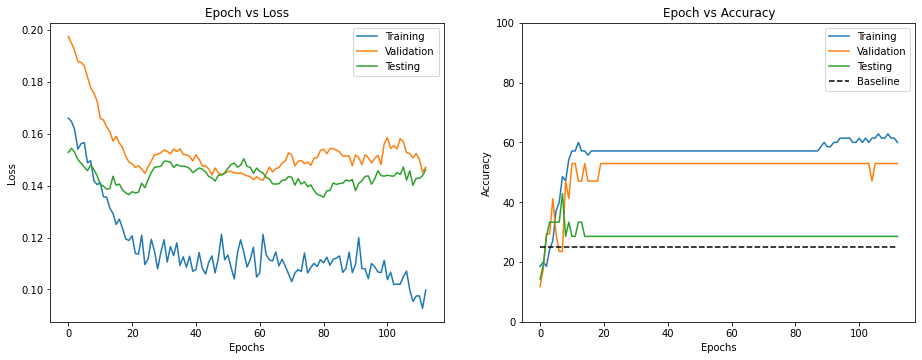

Train/Val/Test Final MSE: [0.12119812369346619, 0.14205424268456066, 0.1448626271227286]
Train/Val/Test Maximum Accuracy: [57.142857142857146, 52.94117647058823, 28.571428571428573]


In [22]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [23]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.06515512201935054, 0.10477510812430599, 0.11508722573163963]
Train/Val/Test Average Accuracy: [80.13664596273291, 59.67320261437908, 51.42857142857143]


## Single prediction results

In [24]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output, CerealTimeKillersLabels)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target, CerealTimeKillersLabels)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', flabels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.15701273 0.73553854 0.21464626 0.22655137] with label  [1]
Target Example: [0.    1.125 0.125 0.   ] with label  [1]
Real Label Example: [ 1. 10.  2.  1.] with label  [1]
------- MSE: 0.05892380326986313  Accuracy: 100.0 %-------

Batch 2  ( Size 1 ):
Output Example: [0.6719221  0.25385892 0.53461653 0.2926631 ] with label  [2]
Target Example: [1.125 0.    1.125 0.   ] with label  [0, 2]
Real Label Example: [10.  1. 10.  1.] with label  [2]
------- MSE: 0.17598207294940948  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.30656943 0.1634723  0.60936505 0.6054178 ] with label  [0]
Target Example: [0.875 0.    0.25  0.   ] with label  [0]
Real Label Example: [8. 1. 3. 1.] with label  [2]
------- MSE: 0.2113775908946991  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.3282308  0.17294544 0.6343943  0.41942292] with label  [0]
Target Example: [0.    0.    0.5   0.875] with label  [3]
Real Label Example: [1. 1. 5. 8.] 